# House Price Prediction

## Import các thư viện cần thiết

In [755]:
# import
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
import math
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

## Tiền xử lý dữ liệu

### Tải dữ liệu từ csv file

In [756]:
# load data
data = pd.read_csv('datasets\HousingPrices-Amsterdam-August-2021.csv', index_col=0)

In [757]:
# show data info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924 entries, 1 to 924
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  924 non-null    object 
 1   Zip      924 non-null    object 
 2   Price    920 non-null    float64
 3   Area     924 non-null    int64  
 4   Room     924 non-null    int64  
 5   Lon      924 non-null    float64
 6   Lat      924 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 57.8+ KB


In [758]:
print(data.head())
print(data.shape)
print(data.columns)

                                  Address      Zip     Price  Area  Room  \
1            Blasiusstraat 8 2, Amsterdam  1091 CR  685000.0    64     3   
2  Kromme Leimuidenstraat 13 H, Amsterdam  1059 EL  475000.0    60     3   
3              Zaaiersweg 11 A, Amsterdam  1097 SM  850000.0   109     4   
4            Tenerifestraat 40, Amsterdam  1060 TH  580000.0   128     6   
5              Winterjanpad 21, Amsterdam  1036 KN  720000.0   138     5   

        Lon        Lat  
1  4.907736  52.356157  
2  4.850476  52.348586  
3  4.944774  52.343782  
4  4.789928  52.343712  
5  4.902503  52.410538  
(924, 7)
Index(['Address', 'Zip', 'Price', 'Area', 'Room', 'Lon', 'Lat'], dtype='object')


### Xử lý dữ liệu bị thiếu

In [759]:
# check nan
data.isna().sum()

Address    0
Zip        0
Price      4
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

In [760]:
# fill nan by interpolate
data = data.dropna()

In [761]:
len(data)

920

In [762]:
# check nan value
data.isna().sum()

Address    0
Zip        0
Price      0
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

<AxesSubplot:>

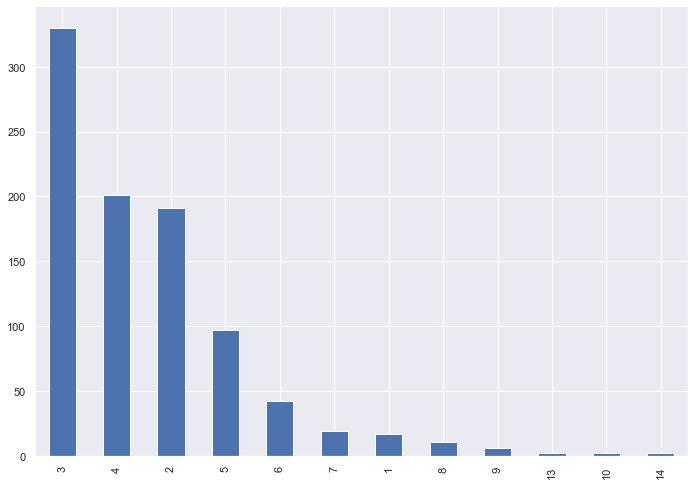

In [763]:
# bar graph for room column
data.Room.value_counts().plot.bar()

In [764]:
# remove room less than 10
data = data[data.Room < 10]

### Xử lý dữ liệu ngoại lai

In [765]:
data.describe()

,Price,Area,Room,Lon,Lat
count,9.140000e+02,914.000000,914.000000,914.000000,914.000000
mean,5.981457e+05,93.119256,3.506565,4.888569,52.363231
std,4.337220e+05,47.564449,1.398818,0.053214,0.024074
min,1.750000e+05,21.000000,1.000000,4.644819,52.291519
25%,3.500000e+05,60.000000,3.000000,4.855832,52.351815
50%,4.650000e+05,82.000000,3.000000,4.886454,52.364499
75%,6.972500e+05,111.000000,4.000000,4.922579,52.377549
max,4.495000e+06,374.000000,9.000000,5.029122,52.423805


<AxesSubplot:xlabel='Price'>

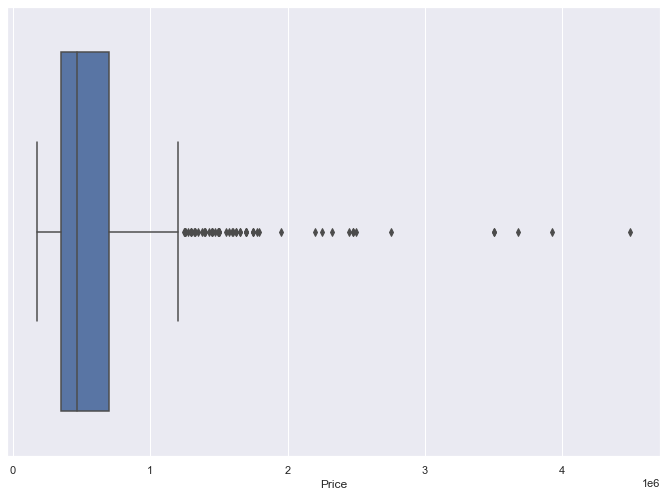

In [766]:
# before remove outliers of price label
sns.boxplot(x='Price', data = data)

In [767]:
# (IQR)
q1 = data.describe()['Price']['25%']
q3 = data.describe()['Price']['75%']
iqr = q3 - q1
max_price = q3 + 1.5 * iqr

In [768]:
# calculate percens of outliers
outliers = data[data['Price'] >= max_price]
outliers_count = outliers['Price'].count()
prices_count = data['Price'].count()
print('Percentage removed: ' + str(round(outliers_count/prices_count * 100, 2)) + '%')

# remove outliers
data = data[data['Price'] < max_price]

Percentage removed: 7.11%


In [769]:
# get street from address
def get_street(address):
    list = address.split()
    word = []
    for element in list:
        if element.isalpha() == True: 
            word.append(element)
        else:
            break
    word = ' '.join(word)
    return word

In [770]:
tqdm.pandas()
data['Zip No'] = data['Zip'].progress_apply(lambda x: x.split()[0])
data['Zip Code'] = data['Zip'].progress_apply(lambda x: x.split()[-1])
data['Address'] = data['Address'].progress_apply(lambda x: x.split(',')[0])
data['Street'] = data['Address'].progress_apply(lambda x: get_street(x))

100%|██████████| 849/849 [00:00<00:00, 170291.43it/s]


In [771]:
# encoder string
lbe = LabelEncoder()
lbe.fit(list(data['Zip Code'].values))
data['Zip Code'] = lbe.transform(list(data['Zip Code'].values))
lbe.fit(list(data['Street'].values))
data['Street'] = lbe.transform(list(data['Street'].values))

<AxesSubplot:xlabel='Price'>

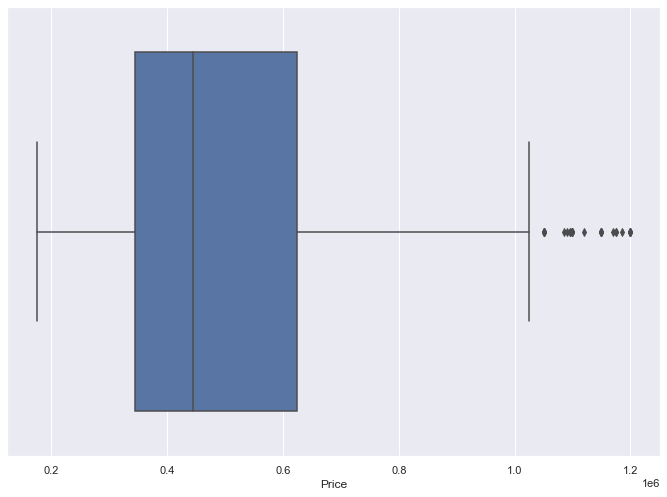

In [772]:
# after remove outliers of price label
sns.boxplot(x='Price', data = data)

In [773]:
# drop unnecessary columns
data = data.drop(columns=['Address', 'Zip'])

In [774]:
data.head()

,Price,Area,Room,Lon,Lat,Zip No,Zip Code,Street
1,685000.0,64,3,4.907736,52.356157,1091,48,58
2,475000.0,60,3,4.850476,52.348586,1059,82,271
3,850000.0,109,4,4.944774,52.343782,1097,250,559
4,580000.0,128,6,4.789928,52.343712,1060,264,457
5,720000.0,138,5,4.902503,52.410538,1036,153,553


## Khám phá dữ liệu

### Biểu đồ hiển thị sự phân bố của nhãn giá

C:\Program Files\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


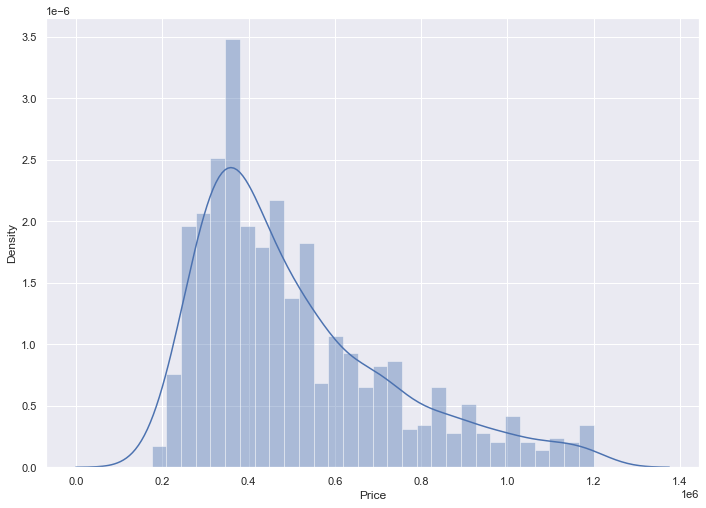

In [775]:
# the histogram shows the distribution of price label
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(data['Price'], bins=30)
plt.show()

### Biểu đồ phân bố của giá với các thuộc tính còn lại

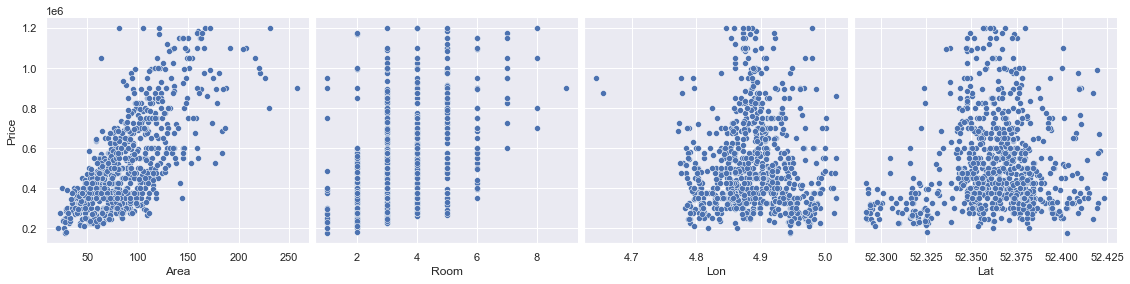

In [776]:
# distribution histogram of price with attributes
sns.pairplot(data, x_vars=['Area', 'Room', 'Lon', 'Lat'], y_vars='Price', height=4, aspect=1, kind='scatter')
plt.show()
# the area attribute has a normal distribution

### Biểu đồ tương quan giữa các thuộc tính

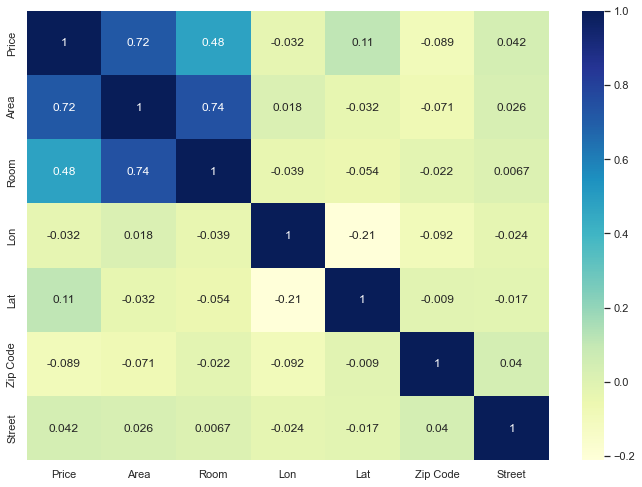

In [777]:
# correlation graph between attributes
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu")
plt.show()

Từ bảng tương quan trên ta thấy được mức đồ tương quan của Area là cao nhất nên ta sẽ chỉ dùng Area làm thuộc tính cho dự đoán giá nhà

## Giải thuật

### Stochastic Gradient Descent(SGD)

In [778]:
def stochastic_gradient_descent(X, y, eta, iter):
    X = np.asarray(X)
    m = X.shape[0]
    n = X.shape[1]
    
    # initial theta
    theta = list(np.random.rand(n + 1))
    y = np.asarray(y)
    len_theta = len(theta)
    
    # loop for number
    for k in range(iter):
#         print(f'Loop {k + 1}:')
        
        # loop for elements
        for i in range(m):
            h_i = 0
            row = np.append(1, X[i])
            
            # cal h_i
            for j in range(len_theta):
                h_i += theta[j] * row[j]
            
            # cal theta
            for j in range(len_theta):
#                 print(f'theta {j} = {theta[j]} + {eta} * ({y[i]} - {h_i}) * {row[j]} = {theta[j] + eta * (y[i] - h_i) * row[j]}')
                theta[j] = theta[j] + eta * (y[i] - h_i) * row[j]
            
#             print(theta)
    return theta

### Batch Gradient Descent(GD)

In [779]:
def batch_gradient_descent(X, y, eta, iter):
    X = np.asarray(X)
    m = X.shape[0]
    n = X.shape[1]
    
    # initial theta
    theta = list(np.random.rand(n + 1))
    y = np.asarray(y)
    len_theta = len(theta)
    
    # loop for number
    for k in range(iter):
#         print(f'Loop {k + 1}:')
        delta = list(np.zeros(n + 1))
        
        # loop for elements
        for i in range(m):
            h_i = 0
            row = np.append(1, X[i])
            
            # cal h_i
            for j in range(len_theta):
                h_i += theta[j] * row[j]
            
            # cal delta
            for j in range(len_theta):
                delta[j] += (y[i] - h_i) * row[j]
            
        # cal theta
        for i in range(len_theta):
            theta[i] = theta[i] + eta * delta[i] 
            
    return theta


### Prediction fuction

In [780]:
def predict_lm(X, theta):
    X = np.asarray(X)
    m = X.shape[0]
    n = X.shape[1]
    y_pred = []
    
    # loop for elements
    for i in range(m):
        pred = 0
        row = np.append(1, X[i])
        # loop for elements in row
        for j in range(n + 1):
            # predict by h function
            pred += theta[j] * row[j]
        
        y_pred.append(pred)
    
    return y_pred

## Đánh giá mô hình

In [781]:
# select area attribute to predict
X = data.drop(columns=['Price'])
y = data['Price']

In [782]:
X.head()

,Area,Room,Lon,Lat,Zip No,Zip Code,Street
1,64,3,4.907736,52.356157,1091,48,58
2,60,3,4.850476,52.348586,1059,82,271
3,109,4,4.944774,52.343782,1097,250,559
4,128,6,4.789928,52.343712,1060,264,457
5,138,5,4.902503,52.410538,1036,153,553


In [783]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [784]:
# len of train and test data
len(X_train), len(X_test)

(594, 255)

### Đánh giá giải thuật qua 10 lần lặp

In [785]:
iteration = 10

### Decision Tree Regressor

In [786]:
# decission tree regression in sklearn
from sklearn.tree import DecisionTreeRegressor

tree_rmse = list()
total_r2 = float()
for i in range(iteration):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # standard data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    # prediction
    y_pred = model.predict(X_test)
    tree_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    total_r2 = total_r2 + r2_score(y_test, y_pred)

tree_rmse = np.array(tree_rmse)
mean_rmse = np.mean(tree_rmse)
print(tree_rmse)
print("Root Mean Squared Error =", mean_rmse)
print('Coefficient of determination:', total_r2/10)

[131208.84788121 116997.89715821 132121.31029837 114960.33858974
 118924.17068462 122207.63396382 135099.07583205 156603.78413041
 109551.83034715 115227.93987539]
Root Mean Squared Error = 125290.28287609588
Coefficient of determination: 0.679345436974117


### Linear Regression

In [787]:
# linearRegression in sklearn
from sklearn.linear_model import LinearRegression

total_mse = float()
total_r2 = float()
for i in range(iteration):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # standard data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # prediction
    y_pred = model.predict(X_test)
    total_mse = total_mse + np.sqrt(mean_squared_error(y_test, y_pred))
    total_r2 = total_r2 + r2_score(y_test, y_pred)

print("Root Mean Squared Error =", total_mse/10)
print('Coefficient of determination:', total_r2/10)

Root Mean Squared Error = 147286.11287673068
Coefficient of determination: 0.5598331139908124


### Lập tìm tốc độ học eta và số lần lặp tối ưu giải thuật custom

In [788]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Tìm eta và số lần lặp cho giải thuật LMS - SGD

In [789]:
# LMS - Stochastic gradient descent (SGD)

for i in range(iteration):
    print(f'Loop {i + 1}')
    eta = 1 / math.pow(10, i + 1)
    iter =  10 * (i + 1)
    theta = stochastic_gradient_descent(X_train, y_train, eta, iter)
    # print(theta)

    y_pred = predict_lm(X_test, theta)
    print('eta =', eta, '; iter =',  iter,"; RMSE = ", np.sqrt(mean_squared_error(y_test, y_pred)), '; Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Loop 1
eta = 0.1 ; iter = 10 ; RMSE =  165578.76164500866 ; Coefficient of determination: 0.40
Loop 2
eta = 0.01 ; iter = 20 ; RMSE =  143864.75474108552 ; Coefficient of determination: 0.55
Loop 3
eta = 0.001 ; iter = 30 ; RMSE =  143402.14310344617 ; Coefficient of determination: 0.55
Loop 4
eta = 0.0001 ; iter = 40 ; RMSE =  156126.2818777348 ; Coefficient of determination: 0.47
Loop 5
eta = 1e-05 ; iter = 50 ; RMSE =  407683.7964416072 ; Coefficient of determination: -2.61
Loop 6
eta = 1e-06 ; iter = 60 ; RMSE =  519398.69352776575 ; Coefficient of determination: -4.86
Loop 7
eta = 1e-07 ; iter = 70 ; RMSE =  535386.2205074454 ; Coefficient of determination: -5.22
Loop 8
eta = 1e-08 ; iter = 80 ; RMSE =  537296.9490303001 ; Coefficient of determination: -5.27
Loop 9
eta = 1e-09 ; iter = 90 ; RMSE =  537516.5327670812 ; Coefficient of determination: -5.27
Loop 10
eta = 1e-10 ; iter = 100 ; RMSE =  537540.693781555 ; Coefficient of determination: -5.27


Sau khi duyệt qua 10 lần ta tìm được eta cho mô hình có chỉ số sai thấp nhất của SGD là 0.01

### Tìm eta và số lần lặp cho giải thuật LMS - GD

In [790]:
# LMS - Batch Gradient descent (GD)
for i in range(iteration):
    print(f'Loop {i + 1}')
    eta = 1 / math.pow(10, i + 1)
    iter =  10 * (i + 1)
    
    theta = batch_gradient_descent(X_train, y_train, eta, iter)
    y_pred = predict_lm(X_test, theta)
    print('eta =', eta, '; iter =',  iter,"; RMSE = ", np.sqrt(mean_squared_error(y_test, y_pred)), '; Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Loop 1
eta = 0.1 ; iter = 10 ; RMSE =  2.079221531775147e+25 ; Coefficient of determination: -9382886597825870030452619822743443996672.00
Loop 2
eta = 0.01 ; iter = 20 ; RMSE =  5.250441879642242e+24 ; Coefficient of determination: -598310535533794753258407050274186199040.00
Loop 3
eta = 0.001 ; iter = 30 ; RMSE =  143328.254028591 ; Coefficient of determination: 0.55
Loop 4
eta = 0.0001 ; iter = 40 ; RMSE =  155267.23392581532 ; Coefficient of determination: 0.48
Loop 5
eta = 1e-05 ; iter = 50 ; RMSE =  407357.4452066766 ; Coefficient of determination: -2.60
Loop 6
eta = 1e-06 ; iter = 60 ; RMSE =  519392.94161010487 ; Coefficient of determination: -4.86
Loop 7
eta = 1e-07 ; iter = 70 ; RMSE =  535386.6777658534 ; Coefficient of determination: -5.22
Loop 8
eta = 1e-08 ; iter = 80 ; RMSE =  537296.3954223263 ; Coefficient of determination: -5.27
Loop 9
eta = 1e-09 ; iter = 90 ; RMSE =  537516.2198876482 ; Coefficient of determination: -5.27
Loop 10
eta = 1e-10 ; iter = 100 ; RMSE =  53

Sau khi duyệt qua 10 lần ta tìm được eta có chỉ số sai thấp nhất của GD là 0.001 và số lần lặp là 40

### Stochastic Gradient Descent (SGD)

In [791]:
SGD_rmse = list()
total_r2 = float()

for i in range(iteration):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # SGD algorithm
    eta = 0.001
    iter = 30
    theta_stochastic = stochastic_gradient_descent(X_train, y_train, eta, iter)
    
    # prediction
    y_pred = predict_lm(X_test, theta_stochastic)
    SGD_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    total_r2 = total_r2 + r2_score(y_test, y_pred)
    
SGD_rmse = np.array(SGD_rmse)
mean_rmse = np.mean(SGD_rmse)
print(SGD_rmse)
print("Root Mean Squared Error =", mean_rmse)
print('Coefficient of determination:', total_r2/10)

[143364.11666213 154040.87100745 151116.21163052 156786.3951708
 139950.02468521 143369.51663662 148624.53218327 155109.74689046
 139402.23698271 141539.48293914]
Root Mean Squared Error = 147330.31347882905
Coefficient of determination: 0.5595112833269325


### Batch Gradient Descent (GD)

In [792]:
total_mse = float()
total_r2 = float()
for i in range(iteration):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # GD algorithm
    eta = 0.001
    iter = 30
    theta_batch = batch_gradient_descent(X_train, y_train, eta, iter)

    # prediction
    y_pred = predict_lm(X_test, theta_batch)
    total_mse = total_mse + np.sqrt(mean_squared_error(y_test, y_pred))
    total_r2 = total_r2 + r2_score(y_test, y_pred)

print("Root Mean Squared Error =", total_mse/10)
print('Coefficient of determination:', total_r2/10)

Root Mean Squared Error = 147305.0599346219
Coefficient of determination: 0.5597235046297415


=> Trong tất cả các giải thuật trên thì giải thuật LMS với hàm cập nhật SGD cho kết quả dự đoán với chỉ số sai thấp nhất:
Mean squared error =  25353472288.87112

In [793]:
# rmse for tree regressor and LMS - SGD
print(SGD_rmse)
print(tree_rmse)

[143364.11666213 154040.87100745 151116.21163052 156786.3951708
 139950.02468521 143369.51663662 148624.53218327 155109.74689046
 139402.23698271 141539.48293914]
[131208.84788121 116997.89715821 132121.31029837 114960.33858974
 118924.17068462 122207.63396382 135099.07583205 156603.78413041
 109551.83034715 115227.93987539]


### Biểu đồ RMSE của 2 giải thuật decision tree regressor và LMS - SGD qua 10 lần lặp

Text(0, 0.5, 'Root Mean Square Error')

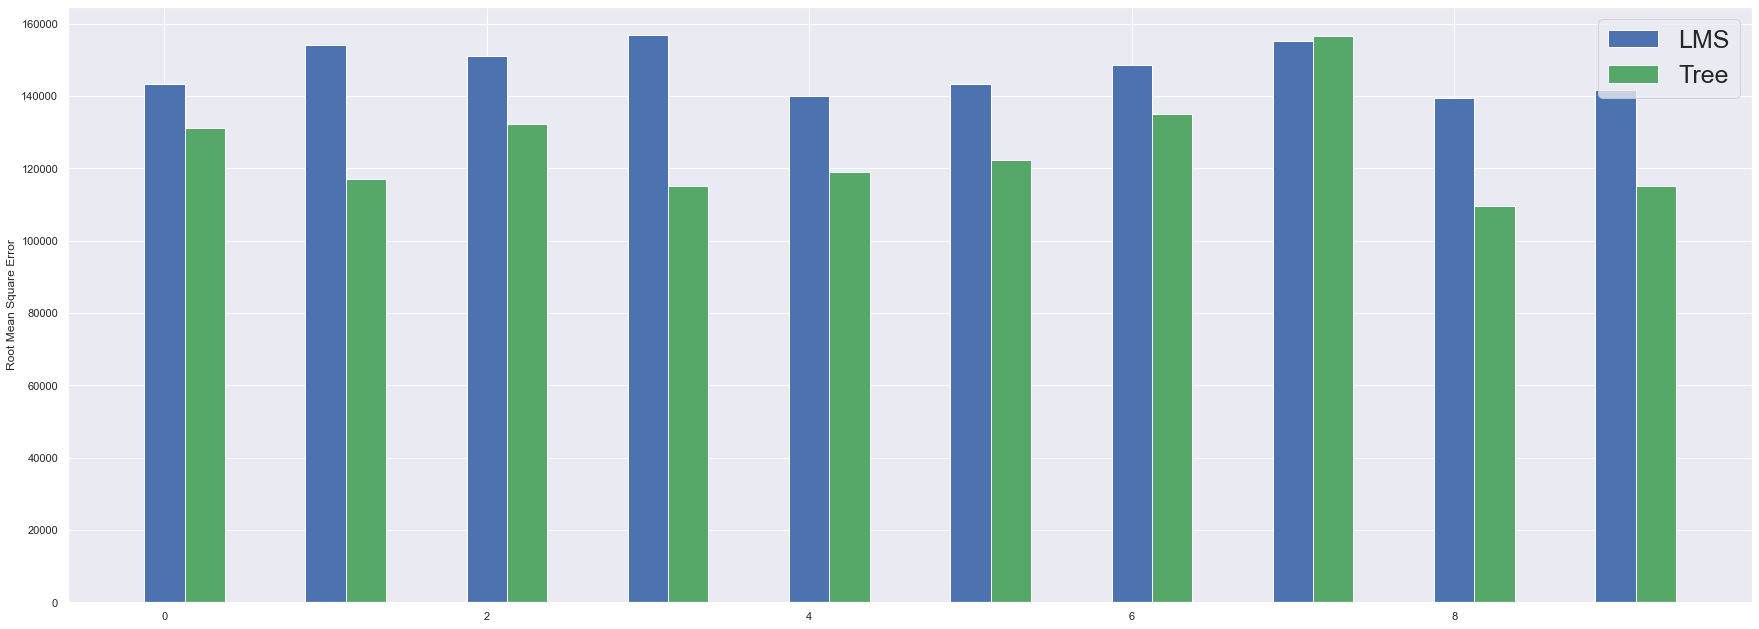

In [794]:
data = [SGD_rmse, tree_rmse]
X = np.arange(iteration)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.legend(labels=['LMS', 'Tree'], prop={'size': 25})
ax.set_ylabel("Root Mean Square Error")